# Intervention


In [1]:
import torch, transformer_lens
from measureLM import visualizing, decoding, patching, scoring

In [11]:
model = transformer_lens.HookedTransformer.from_pretrained("tiny-stories-instruct-33M").to("cpu")
model.cfg.spacing = "Ġ"
model.tokenizer.pad_token = model.tokenizer.eos_token

Using pad_token, but it is not set yet.


Loaded pretrained model tiny-stories-instruct-33M into HookedTransformer
Moving model to device:  cpu


### 1) Get activations


prompt 0
layer 3: [(0.0137, 'France'), (0.3333, 'Paris'), (0.0044, 'Poland'), (0.0, 'Warsaw')]


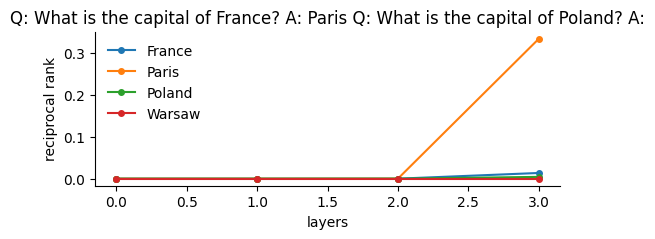

In [12]:
prompts = ['Q: What is the capital of France? A: Paris Q: What is the capital of Poland? A:']

logits, activs, tokens = decoding.encode(prompts, model)
layer_scores = decoding.early_decoding(activs, model)


token_candidates = ["France", "Paris", "Poland", "Warsaw"]

tok_idx = scoring.token_select(tokens, model)
scored_tokens = scoring.scores_to_tokens(layer_scores, tok_idx, model, mode=token_candidates)
visualizing.visualize_token_ranks(scored_tokens, token_candidates, prompts)

### (2) Use activations to intervene

['Ġand', 'Ġbut', 'Ġa']
['Ġand', 'Ġbut', 'Ġa']

prompt 0
layer 3: [(0.0067, 'Germany'), (0.0003, 'mug'), (0.0003, 'table'), (0.0, 'Berlin'), (0.0, 'Warsaw')]


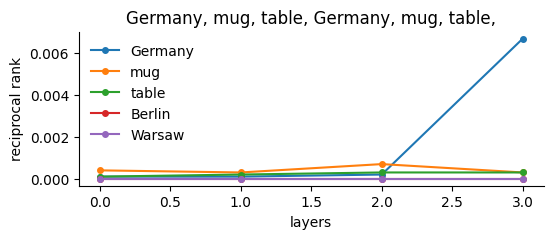

In [13]:
new_prompts = ["Germany, mug, table, Germany, mug, table,"]
new_logits, new_activs, new_tokens = decoding.encode(new_prompts, model)
pred = model.tokenizer.convert_ids_to_tokens(torch.topk(new_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

patch_map = patching.create_hook_mapping(model, extract_l=(15, 40),patch_l=(15, 40))
patch_logits, resid_post = patching.intervene(new_tokens, activs, model, patch_map, extract_tok_idx=-1)
resid_layer_scores = decoding.early_decoding(resid_post, model)

pred = model.tokenizer.convert_ids_to_tokens(torch.topk(patch_logits[:, -1, :], k=3).indices.tolist()[0])
print(pred)

new_token_candidates = ["Germany", "mug", "table", "Berlin", "Warsaw"]

## scoring
tok_idx = scoring.token_select(new_tokens, model)
scored_tokens = scoring.scores_to_tokens(resid_layer_scores, tok_idx, model, mode=new_token_candidates)
visualizing.visualize_token_ranks(scored_tokens, new_token_candidates, new_prompts)
